# Analysis of Gay-Berne fluid NVT simulation, v 3.0 on cpu

A simple simulation of a Gay-Berne fluid (2019-03-21)

## Examine the output

Use matplotlib to plot the logged quantities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def meanAndStdError(x):
    mean_x= np.mean(x)
    stderr_x=  np.std(x)/np.sqrt(len(x))
    return(mean_x, stderr_x)

In [3]:
def autocorrelation(x):
    xp = x-np.mean(x);
    result = np.correlate(xp, xp, mode='full')
    return result[result.size // 2:]

Load data from the log file

In [4]:
data = np.genfromtxt(fname='log_rho_0.005_T_0.7.log', skip_header=True);

slice_step = 2;
time = data[:,0][0:-1:slice_step]
translational_K = data[:,1][0:-1:slice_step]
rotational_K = data[:,2][0:-1:slice_step]
potential = data[:,3][0:-1:slice_step]
temp = data[:,4][0:-1:slice_step]
press =  data[:,5][0:-1:slice_step]

Plot translational and rotational kinetic energies vs time

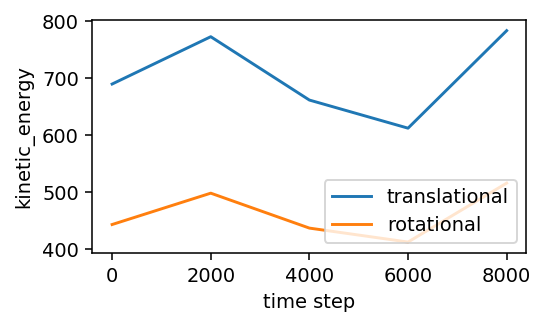

In [5]:
plt.figure(figsize=(4,2.2), dpi=140);
plt.plot(time, translational_K);
plt.plot(time, rotational_K);
plt.xlabel('time step');
plt.ylabel('kinetic_energy');
plt.legend(['translational', 'rotational'], loc='lower right');

In [6]:
meanAndStdError(translational_K)[0]/meanAndStdError(rotational_K)[0]

1.5269667231817032

In [7]:
ac_translational_K= autocorrelation(translational_K)

In [8]:
ac_rotational_K= autocorrelation(rotational_K)

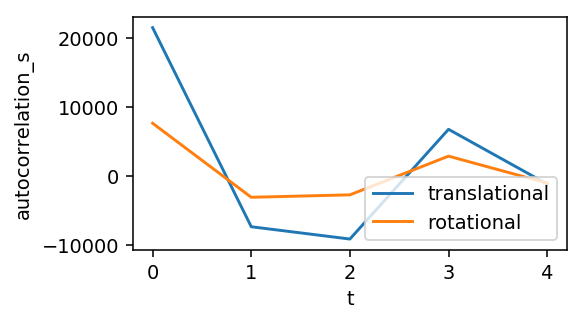

In [9]:
plt.figure(figsize=(4,2.2), dpi=140);


plt.plot(
    np.arange(len(ac_translational_K)), 
    ac_translational_K);

plt.plot(
    np.arange(len(ac_rotational_K)), 
    ac_rotational_K);

plt.xlabel('t');
plt.ylabel('autocorrelation_s');
plt.legend(['translational', 'rotational'], loc='lower right');


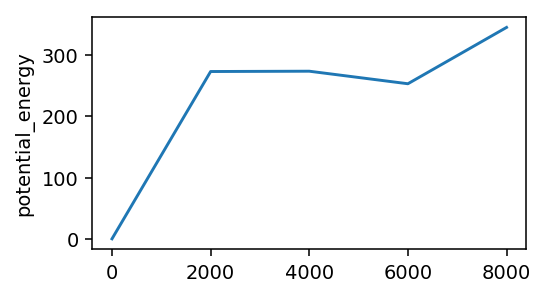

In [10]:
plt.figure(figsize=(4,2.2), dpi=140);
plt.plot(time, potential);
plt.ylabel('potential_energy');
#plt.ylim((-80,0))

In [11]:
meanAndStdError(potential)

(228.98563768, 53.078930221972826)

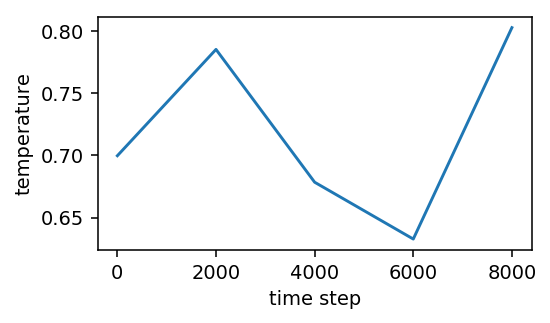

In [12]:
plt.figure(figsize=(4,2.2), dpi=140);
plt.plot(time, temp);
plt.xlabel('time step');
plt.ylabel('temperature');
#plt.ylim((0,2))

In [13]:
meanAndStdError(temp)

(0.71968444014, 0.0288505959644825)

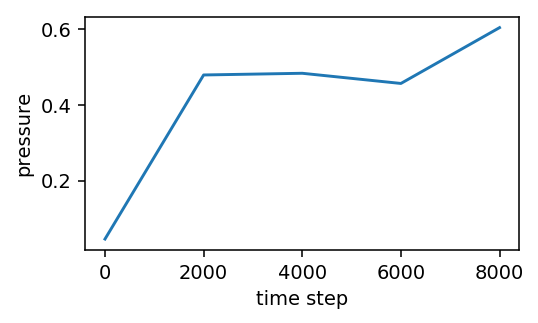

In [14]:
plt.figure(figsize=(4,2.2), dpi=140);
plt.plot(time, press);
plt.xlabel('time step');
plt.ylabel('pressure');
#plt.ylim((0,0.5))

In [15]:
meanAndStdError(press)

(0.41319844946999995, 0.08535511355603334)

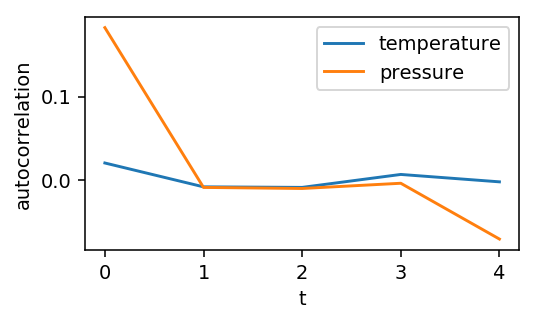

In [16]:
ac_temp=  autocorrelation(temp)
ac_press= autocorrelation(press)


plt.figure(figsize=(4,2.2), dpi=140);


plt.plot(
    np.arange(len(ac_temp)), 
    ac_temp);

plt.plot(
    np.arange(len(ac_press)), 
    ac_press);

plt.xlabel('t');
plt.ylabel('autocorrelation');
plt.legend(['temperature', 'pressure'], loc='upper right');
#plt.xlim(0,50);

# Read data from the trajectory file

In [17]:
import gsd
import gsd.hoomd

In [18]:
# To show orientations, we use arrows rotated by the quaternions.
from mpl_toolkits.mplot3d.axes3d import Axes3D

# These functions are adapted from the rowan quaternion library.
# See rowan.readthedocs.io for more information.
def quat_multiply(qi, qj):
    """Multiply two sets of quaternions."""
    output = np.empty(np.broadcast(qi, qj).shape)

    output[..., 0] = qi[..., 0] * qj[..., 0] - \
        np.sum(qi[..., 1:] * qj[..., 1:], axis=-1)
    output[..., 1:] = (qi[..., 0, np.newaxis] * qj[..., 1:] +
                       qj[..., 0, np.newaxis] * qi[..., 1:] +
                       np.cross(qi[..., 1:], qj[..., 1:]))
    return output

def quat_rotate(q, v):
    """Rotate a vector by a quaternion."""
    v = np.array([0, *v])
    
    q_conj = q.copy()
    q_conj[..., 1:] *= -1
    
    return quat_multiply(q, quat_multiply(v, q_conj))[..., 1:]

In [19]:
t1= gsd.hoomd.open('trajectory_rho_0.005_T_0.7.gsd', 'rb')
print( t1[0].configuration.box )

Lx = t1[0].configuration.box[0]
rho =  t1[0].particles.N / Lx**3

print(rho)

[21.6 21.6 21.6  0.   0.   0. ]
0.5787036730428793


In [20]:
def orientationPlot(step, t):
    L = t[0].particles.N
    positions = t[step].particles.position[0:L];
    
    orientations = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(orientations, np.array([1, 0, 0]))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
                arrowheads[:, 0], arrowheads[:, 1], arrowheads[:, 2])
    ax.set_title("Orientations", fontsize=16);

In [ ]:
orientationPlot(9, t1)

In [21]:
def nematicOrderTensor(step, t):
 
    L = t[0].particles.N
    quaternions = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(quaternions, np.array([1, 0, 0]))
    
    
    results = []
    for i in range(5):
        results.append( np.outer(arrowheads[i],arrowheads[i])  )
        
    Q = np.mean(results, axis=0)  # calculate mean without flattening array
    Q -= np.identity(3)/3.0       # subtract Identity/3
    
    return(Q)


In [22]:
nematicOrderTensor(0,t1)

array([[ 0.66666667,  0.        ,  0.        ],
       [ 0.        , -0.33333333,  0.        ],
       [ 0.        ,  0.        , -0.33333333]])

In [23]:
def nematization(step, t):
        Q = nematicOrderTensor(step,t)
        
        eigen_values, eigen_vectors = np.linalg.eig(Q)
        idx = eigen_values.argsort()[::-1]   
        
        eigen_values = eigen_values[idx]
       
        return(1.5*eigen_values[0])

In [24]:
nematization(9,t1)

0.9661654168290712

In [25]:
def sList(t):

    s = []
    for i in range(len(t)):
        s.append(nematization(i,t))
        
    return(s)

(0, 1.1)

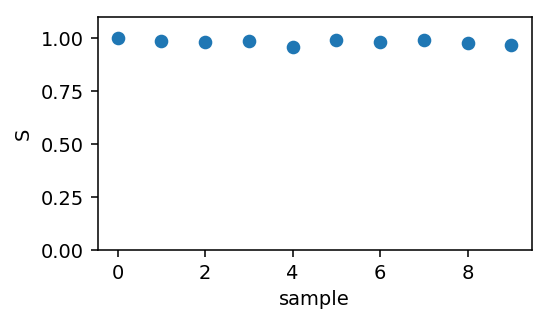

In [26]:
plt.figure(figsize=(4,2.2), dpi=140);

s1= sList(t1)

plt.scatter(
    np.arange(len(s1)), 
    s1);

plt.xlabel('sample');
plt.ylabel('S');
plt.ylim((0,1.1))

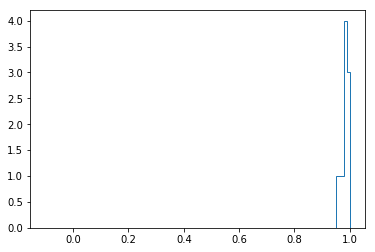

In [27]:
plt.hist( [s1], bins='auto', range=(-0.1,1), density=False, histtype='step');

In [28]:
meanAndStdError(s1)

(0.982568837558968, 0.003723999436989531)

In [29]:
ac1= autocorrelation(s1)

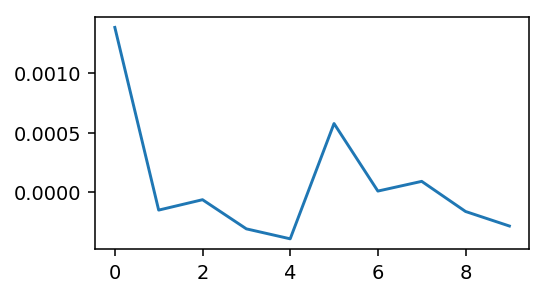

In [30]:
plt.figure(figsize=(4,2.2), dpi=140);


plt.plot(
    np.arange(len(ac1)), 
    ac1);